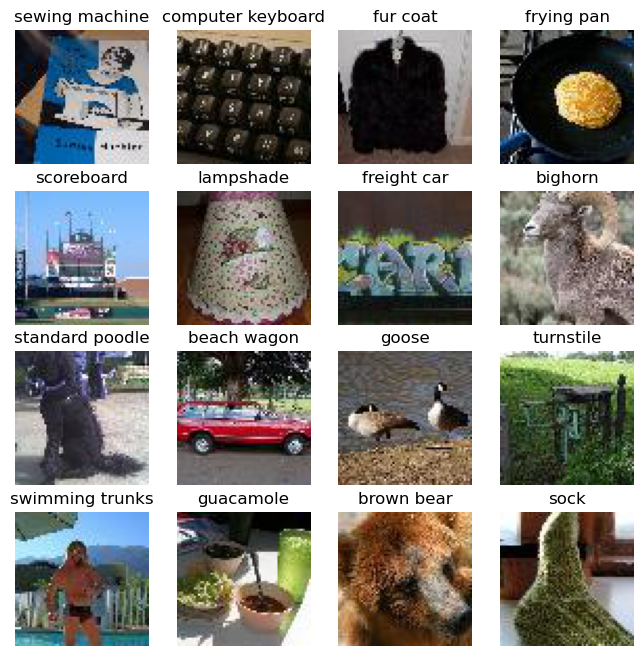

In [83]:
# 这是 Tiny Imagenet 数据集的预处理
'''
Tiny Imagenet 有 200 个类。 每个类有 500 张训练图像、50 张验证图像和 50 张测试图像。
所以一共 100000 张训练图像、10000 张验证图像和 10000 张测试图像。
train 为训练集, val 为验证集。这俩数据集有标签。
这个数据集大部分是 RGB, 但是也有少部分是灰度图。
图片大小都是 64x64。
'''
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
import torch

class TinyImagenet(Dataset):
    mapping = {}    # 类的静态变量, 用来后面验证正确性用的

    def __init__(self, root, type):
        super().__init__()
        self.root = root
        self.type = type
        
        if not os.path.exists(root):
            raise ValueError("dataset path not right!")
        if type not in ['train', 'val']:
            raise ValueError("dataset type not right!")
        
        self.annotations_file = self.get_annotations_file(type)

    def get_annotations_file(self, type):
        df = pd.DataFrame(columns=['img_name', 'label'])
        rows = []
        mapping = {}
        with open(os.path.join(self.root, 'wnids.txt'), 'r') as f:
            lines = f.readlines()
            lines = [line.strip() for line in lines]
            for idx, line in enumerate(lines):
                mapping[line] = idx
                TinyImagenet.mapping[line] = idx

        if type == 'train':
            '''
            去遍历 train 下面的每个子文件夹
                对于每个子文件夹, 通过文件夹名 mapping 找到对应的 label
                对于每个子文件夹, 进入其下的 txt, 把第一列读出来, 作为 img_names, 然后把所有 pairs 存到 rows 里
            '''
            path_train = os.path.join(self.root, 'train')
            for entry in os.listdir(path_train):
                label = mapping[entry]
                with open(os.path.join(path_train, entry, entry + '_boxes.txt'), 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        img_name = line.split('\t')[0]
                        rows.append({'img_name': img_name, 'label': label})

        elif type == 'val':
            '''
            进入 val 下的 txt, 把前两列读出来, 然后用 mapping 换为 label 即可
            '''
            with open(os.path.join(self.root, 'val', 'val_annotations.txt'), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    img_name, id, _, _, _, _ = line.split('\t')
                    label = mapping[id]
                    rows.append({'img_name': img_name, 'label': label})

        df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)
        return df
    
    def __len__(self):
        return len(self.annotations_file)
    
    def __getitem__(self, idx):
        label = self.annotations_file.iloc[idx, 1]
        img_name = self.annotations_file.iloc[idx, 0]

        if self.type == 'train':
            catagory = img_name.split('_')[0]
            img = read_image(os.path.join(self.root, 'train', catagory, 'images', img_name))
        elif self.type == 'val':
            img = read_image(os.path.join(self.root, 'val', 'images', img_name))

        if img.shape[0] == 1: # 有可能出现灰度图, 要转为 RGB
            img = img.repeat(3, 1, 1) # tensor.repeat(x, y, z) 表示下标为 0 的维度重复 x 次, 依次类推
        img = img.to(torch.float32) / 255.0 # read_image 读出来的是 torch.uint8, 要转为 [0, 1]

        return img, label
        
# 验证下自定义数据集声明是否正确 (检查图片与标签的对应关系)
train_TinyImagenetData = TinyImagenet(root="./data/tiny-imagenet-200", type="train")
test_TinyImagenetData = TinyImagenet(root="./data/tiny-imagenet-200", type="val")

from torch.utils.data import DataLoader
train_TinyImagenetDataloader = DataLoader(train_TinyImagenetData, batch_size=8, shuffle=True)
test_TinyImagenetDataloader = DataLoader(test_TinyImagenetData, batch_size=8, shuffle=True)

mapping = {}
with open('./data/tiny-imagenet-200/words.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        id, desc = line.split('\t')
        mapping[TinyImagenet.mapping.get(id)] = desc.strip().split(',')[0]  # 太长了, 只取第一个

a = next(iter(train_TinyImagenetDataloader))
b = next(iter(test_TinyImagenetDataloader))
# print(a[0][x].shape, a[1][x]) # x 为 0 到 7
# print(b[0][x].shape, b[1][x]) # x 为 0 到 7

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8))
rows, cols = 4, 4
for i, j in zip(range(1, 8 + 1), range(0, 8)):
    fig.add_subplot(rows, cols, i)
    plt.title(mapping[a[1][j].item()])
    plt.axis('off')
    plt.imshow(a[0][j].permute(1, 2, 0))
for i, j in zip(range(9, 16 + 1), range(0, 8)):
    fig.add_subplot(rows, cols, i)
    plt.title(mapping[b[1][j].item()])
    plt.axis('off')
    plt.imshow(b[0][j].permute(1, 2, 0))
plt.show()

# 总结: 主要还是要把 self.annotations_file 弄出来, 这玩意弄出来后边都好写

In [84]:
# 任务:
# 1. 读入 FashionMNIST, CIFAR10, Tiny Imagenet(来自CS231n课程项目) 数据集
# 2. 构建 CNN 网络, 写 train/eval loop, 带调试信息
# 3. 训练, 保存, 加载

# 数据集导入
from torchvision import datasets, transforms

op_dataset = 2  # 0: FashionMNIST, 1: CIFAR10, 2: TinyImagenet
op_model = 3    # 0: LetNet, 1: AlexNet, 2: VGGNet, 3: ResNet

if op_dataset == 0:
    catagoty_num = 10
    dataset_name = 'FashionMNIST'
    train_data = datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    )
    test_data = datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transforms.ToTensor(),
    )
elif op_dataset == 1:
    catagoty_num = 10
    dataset_name = 'CIFAR10'
    train_data = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    )
    test_data = datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transforms.ToTensor(),
    )
elif op_dataset == 2:
    catagoty_num = 200
    dataset_name = 'TinyImagenet'
    train_data = TinyImagenet('./data/tiny-imagenet-200', 'train')
    test_data = TinyImagenet('./data/tiny-imagenet-200', 'val')

from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size= batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
print('训练集和测试集的样本数量')
print(len(train_data), len(test_data))

训练集和测试集的样本数量
100000 10000


In [85]:
# LetNet
from torch import nn
import torch

sample = train_data[0][0]

class LetNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=sample.shape[0], out_channels=6, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.get_flatten_dim(), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, catagoty_num)

    def get_flatten_dim(self):
        with torch.no_grad():
            x = self.pool(self.conv1(sample.unsqueeze(0)))  # 增加 batch 维度
            x = self.pool(self.conv2(x))
            return x.numel()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [86]:
# AlexNet
# 为了适应我的小数据集, 参数稍微调整了一下, 网络架构没变
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=sample.shape[0], out_channels=64, kernel_size=11, stride=3, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, 5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, 2, padding=1)
        self.conv4 = nn.Conv2d(384, 256, 2, padding=1)
        self.conv5 = nn.Conv2d(256, 256, 2, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.get_input_dim(), 4096)
        self.dropout = nn.Dropout(p=0.5)    # 每个神经元有 50% 的概率被丢弃, model.eval() 时会自动在 forward() 中被关闭 (p 默认值为 0.5)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, catagoty_num)
    
    def get_input_dim(self):
        with torch.no_grad():
            x = self.pool(self.relu(self.conv1(sample.unsqueeze(0))))
            x = self.pool(self.relu(self.conv2(x)))
            x = self.relu(self.conv3(x))
            x = self.relu(self.conv4(x))
            x = self.pool(self.relu(self.conv5(x)))
            return x.numel()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(self.relu(self.conv5(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        logits = self.fc3(x)
        return logits

In [87]:
# VGGNet
class VGGNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 像这种非常深的网络, 用 nn.Sequential() 会更简洁
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=sample.shape[0], out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(self.get_flatten_dim(), 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, catagoty_num)
        )

    def get_flatten_dim(self):
        with torch.no_grad():
            x = self.conv_layers(sample.unsqueeze(0))
            return x.numel()
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        logits = self.fc_layers(x)
        return logits

In [88]:
# ResNet

# 残差块 (内含 2 个卷积层 + 跳跃连接)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # ⬆️: bias 就是每层输出通道要减去的那个常数, 默认是 True
        # 这里设为 False 是因为后面接着的 nn.BatchNorm2d() 里, 有 beta, gamma 这俩学习参数
        # 其中 beta 就已经是偏置的作用了

        self.bn = nn.BatchNorm2d(out_channels)
        # ⬆️: 标准化每一个通道, 标准化就是均值为0, 方差为1
        # 除此之外, 还需注意内置还有学习参数 beta, gamma, 用于调整标准化后的均值和方差
        
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False) # 这一层卷积不会改变 HxW 尺寸, 和通道数
        
        # 跳跃连接 (shortcut means "捷径" )
        self.shortcut = nn.Sequential() # 若尺寸和通道图不变, 也就是前后维度一样, 那么直接加上 input 即可
        if stride != 1 or in_channels != out_channels:  # 若尺寸改变 or 通道数改变
        # ⬆️: 若 stride=1 尺寸是不会变的, 因为此时 stride=1, padding=1, kernel_size=3
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                # ⬆️: 通道对齐; 尺寸对齐
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = self.relu(self.bn(self.conv1(x)))
        out = self.bn(self.conv2(out))
        out += self.shortcut(x) # 因为这里有跳跃连接, 所以要用 out, 而不是一直用 x
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    # block 是残差块类, num_blocks 是每个 layer 里有多少个残差块
    def __init__(self, block, num_blocks):
        super().__init__()
        
        self.conv1 = nn.Conv2d(sample.shape[0], 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.in_channels = 64   # 这里是 64 是因为要接着上边的 conv1 的 out_channels

        # 每个layer包含多个残差块
        self.layer1 = self._make_layer(block, num_blocks[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, num_blocks[1], 128, 2)
        self.layer3 = self._make_layer(block, num_blocks[2], 256, 2)
        self.layer4 = self._make_layer(block, num_blocks[3], 512, 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # 把每个通道都变为一个 (1, 1) 的矩阵, 其实就是一个数了此时
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, catagoty_num)
        
    def _make_layer(self, block, num_blocks, out_channels, stride):
        layers = []
        # 每一层的第一个残差块负责改变尺寸和通道数翻倍
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels # 这里记得更新一下, 衔接起来
        # 后续的残差块不改变尺寸和通道
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        logits = self.fc(x)
        
        return logits

'''
总结:
总的来看流程: conv1 -> bn1 -> relu -> maxpool
            -> layer1 -> layer2 -> layer3 -> layer4
            -> avgpool -> flatten -> fc

通道数从进入 layer1 前的 64, 每层翻倍, 最后到 512.
每一层内部, 第一个残差块负责改变尺寸, 以及通道的翻倍. 后续的残差块通道不变, 尺寸不变.

写了那么多代码了, 总结一下吧:
    在我看来, 所谓通道数, 其实就是捕捉到的特征数, 也就是说, 通道数越多, 模型越能捕捉到更多的特征.
    然后卷积操作, 也就是 kernel_size, stride, padding 这些参数, 是在改变图的尺寸
    所以对于一个卷积核 nn.Conv2d() 来说, 我们只需要关注卷积前后的通道数变化, 以及尺寸变换
        通道数变化通过 in_channels, out_channels 来控制
        尺寸变化通过 kernel_size, stride, padding 来控制

然后这个 ResNet 每一个 layer, 都会对通道数翻倍, 然后尺寸减半(除了第一层 layer 不会下采样)
'''

'\n总结:\n总的来看流程: conv1 -> bn1 -> relu -> maxpool\n            -> layer1 -> layer2 -> layer3 -> layer4\n            -> avgpool -> flatten -> fc\n\n通道数从进入 layer1 前的 64, 每层翻倍, 最后到 512.\n每一层内部, 第一个残差块负责改变尺寸, 以及通道的翻倍. 后续的残差块通道不变, 尺寸不变.\n\n写了那么多代码了, 总结一下吧:\n    在我看来, 所谓通道数, 其实就是捕捉到的特征数, 也就是说, 通道数越多, 模型越能捕捉到更多的特征.\n    然后卷积操作, 也就是 kernel_size, stride, padding 这些参数, 是在改变图的尺寸\n    所以对于一个卷积核 nn.Conv2d() 来说, 我们只需要关注卷积前后的通道数变化, 以及尺寸变换\n        通道数变化通过 in_channels, out_channels 来控制\n        尺寸变化通过 kernel_size, stride, padding 来控制\n\n然后这个 ResNet 每一个 layer, 都会对通道数翻倍, 然后尺寸减半(除了第一层 layer 不会下采样)\n'

In [89]:
# train/eval

from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if op_model == 0:
    model = LetNet().to(device)
    model_name = 'LetNet'
elif op_model == 1:
    model = AlexNet().to(device)
    model_name = 'AlexNet'
elif op_model == 2:
    model = VGGNet().to(device)
    model_name = 'VGGNet'
elif op_model == 3:
    model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device) # ResNet-18
    model_name = 'ResNet'
    
loss_fn = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

def train_loop(model, dataloader, loss_fn, optimizer):
    model.train()
    samples_size = len(dataloader.dataset)
    batches_size = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        logits_pred = model(X)
        loss = loss_fn(logits_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0 or batch == batches_size - 1:
            print(f'loss:{loss:>7.2f} | {batch * batch_size + len(y)}/{samples_size}')

def test_loop(model, dataloader, loss_fn):
    model.eval()
    samples_size = len(dataloader.dataset)
    batches_size = len(dataloader)
    loss_sum = 0
    acc_sum = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            logits_pred = model(X)
        loss_sum += loss_fn(logits_pred, y)
        acc_sum += (logits_pred.argmax(dim=1) == y).sum()
    print(f'loss:{(loss_sum/batches_size):>7.2f} | acc:{(acc_sum/samples_size*100):>7.2f}%')

epochs = 10
for t in range(1, epochs + 1):
    print(f'Epoch {t} -------------------------')
    train_loop(model, train_dataloader, loss_fn, optimizer)
    test_loop(model, test_dataloader, loss_fn)
    print()

# 保存/加载模型
import os

if not os.path.exists('./model'):
    os.makedirs('./model')
save_name = os.path.join('./model', model_name + '_' + dataset_name + '.pth')
torch.save(model.state_dict(), save_name)

model_new = model
model_new.load_state_dict(torch.load(save_name))
model_new.eval()
with torch.no_grad():
    y_pred = model_new(sample.unsqueeze(0).to(device)).argmax()
print(y_pred, train_data[0][1])

Epoch 1 -------------------------
loss:   5.40 | 64/100000
loss:   5.24 | 6464/100000
loss:   4.77 | 12864/100000
loss:   4.46 | 19264/100000
loss:   4.58 | 25664/100000
loss:   4.62 | 32064/100000
loss:   4.43 | 38464/100000
loss:   4.46 | 44864/100000
loss:   4.09 | 51264/100000
loss:   3.98 | 57664/100000
loss:   4.36 | 64064/100000
loss:   4.29 | 70464/100000
loss:   4.27 | 76864/100000
loss:   3.69 | 83264/100000
loss:   3.21 | 89664/100000
loss:   3.87 | 96064/100000
loss:   4.03 | 100000/100000
loss:   4.73 | acc:   6.24%

Epoch 2 -------------------------
loss:   3.61 | 64/100000
loss:   3.51 | 6464/100000
loss:   3.79 | 12864/100000
loss:   3.77 | 19264/100000
loss:   3.69 | 25664/100000
loss:   3.49 | 32064/100000
loss:   3.38 | 38464/100000
loss:   3.72 | 44864/100000
loss:   3.25 | 51264/100000
loss:   3.15 | 57664/100000
loss:   3.46 | 64064/100000
loss:   3.38 | 70464/100000
loss:   3.37 | 76864/100000
loss:   3.07 | 83264/100000
loss:   3.12 | 89664/100000
loss:   3.31 |